## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def getCameraCalibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        plt.imshow(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


## Pipeline components

### Distortion correction

In [2]:
def distortionCorrection(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Color space/thresholding

In [18]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(gray)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def getThresholdImg(img, showImage=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    abs_sobel_img = abs_sobel_thresh(img)
    mag_sobel_img = mag_thresh(img)
    dir_sobel_img = dir_threshold(img)

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((abs_sobel_img, mag_sobel_img, dir_sobel_img))
    color_binary = color_binary * 255
    
    sobel_binary = np.zeros_like(s_binary)
    sobel_binary[(abs_sobel_img == 1) & (mag_sobel_img == 1)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    print(combined_binary.shape)

    if showImage == True:
        # Plotting thresholded images
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
        ax1.set_title('Stacked sobel thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined sobel thresholds')
        ax2.imshow(sobel_binary)
        
        ax3.set_title('S channel')
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('Combined')
        ax4.imshow(combined_binary, cmap='gray')
        
    return combined_binary

### Perspective transform

In [101]:
def perspectiveTransform(img, x_loc=(555, 200, 1100, 730), y_loc=(470, 680)):
    src = np.float32([[x_loc[0], y_loc[0]],[x_loc[1], y_loc[1]],
                      [x_loc[2], y_loc[1]],[x_loc[3], y_loc[0]]])
    print(src)
    dst = np.float32([[100, 0],[100,720],[1180,720],[1180,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
    return warped

## Run pipeline

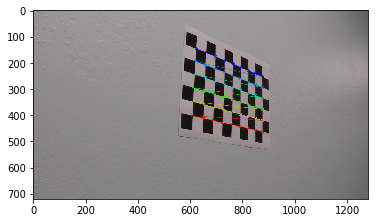

In [23]:
mtx, dist = getCameraCalibration()

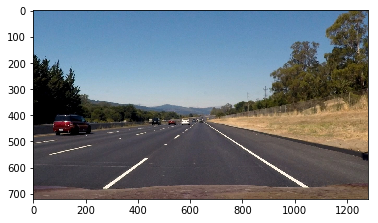

In [103]:
img = cv2.imread('../test_images/straight_lines2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

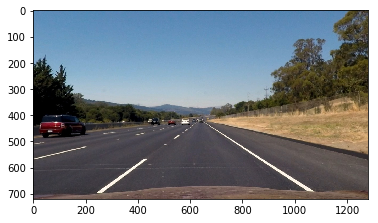

In [104]:
img = distortionCorrection(img,mtx,dist)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

(720, 1280)


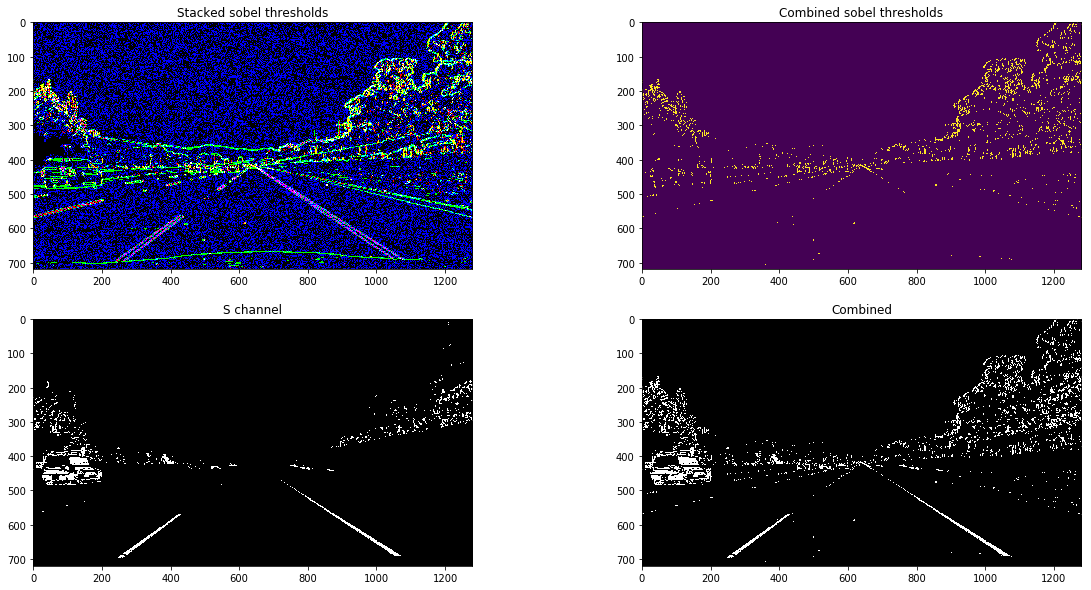

In [105]:
img_b = getThresholdImg(img, True)

[[  555.   470.]
 [  200.   680.]
 [ 1100.   680.]
 [  730.   470.]]
(720, 1280)


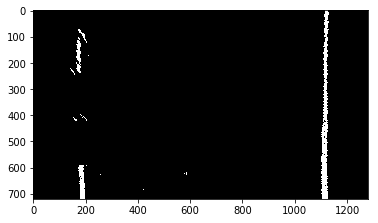

In [106]:
img_p = perspectiveTransform(img_b)
print(img_p.shape)
plt.imshow(img_p, cmap='gray')